In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.0 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=0302f5d30ccaf021e6a2560c3ab98f6f7ab2bbb1080fab

In [ ]:
import torch


print("Runtime restarted, checking GPU...")

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Before anything: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Runtime restarted, checking GPU...
Thu Mar 27 18:36:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             47W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+------------

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from efficientnet_pytorch import EfficientNet
from transformers import AutoModel, AutoTokenizer
import json
import os
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
image_folder = "/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation"
json_file = "/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Text_Augmented_Cleaned3.json"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
from sklearn.model_selection import train_test_split

with open(json_file, 'r') as f:
    data = json.load(f)

label_mapping = {
    "Congenital & Genetic": 0,
    "Trauma & Physical Injuries": 1,
    "Vascular & Circulatory": 2,
    "Infections": 3,
    "Neoplasm - Benign & Sarcoma": 4,
    "Neoplasm - Carcinoma": 5,
    "Neoplasm - Other Malignant": 6,
    "Inflammatory & Autoimmune": 7,
    "Metabolic & Endocrine": 8,
    "Cysts & Degenerative Conditions": 9,
    "Obstruction & Structural Abnormalities": 10,
    "Miscellaneous Conditions": 11
}

patient_data = []

for entry in data:
    image_files = entry.get('MRI', []) + entry.get('TAC', [])
    image_paths = [os.path.join(image_folder, f"{img}.png") for img in image_files]

    case_text = (
        f"Title: {entry['Case']['Title']}\n"
        f"History: {entry['Case'].get('History', '')}\n"
        f"Exam: {entry['Case'].get('Exam', '')}\n"
        f"Differential Diagnosis: {entry['Case'].get('Differential Diagnosis', '')}"
    )

    location = entry.get("Location", "Unknown")

    label = entry['Class/Label']
    numeric_label = label_mapping.get(label, -1)

    patient_data.append({
        "images": image_paths,
        "text": case_text,
        "label": numeric_label,
        "location": location
    })

train_data, test_data = train_test_split(patient_data, test_size=0.2, random_state=42)

print(f"Training size: {len(train_data)}, Testing size: {len(test_data)}")
print(f"First entry: {train_data[0]}")
print(f"Label mapping: {label_mapping}")


Training size: 1892, Testing size: 474
First entry: {'images': ['/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation/MPX2204_synpic23796_aug_1.png', '/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation/MPX2204_synpic23797_aug_1.png', '/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation/MPX2204_synpic23798_aug_1.png', '/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation/MPX2204_synpic23799_aug_1.png', '/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation/MPX2204_synpic23800_aug_1.png', '/content/drive/MyDrive/GP2/3_After_Text_Augmentation/Images_After_Text_Augmentation/MPX2204_synpic23801_aug_1.png'], 'text': 'Title: Quadriceps tendon rupture, Medial retinacular tear\nHistory: 48 y/o male presents with pain in anterior aspect of distal left thigh, superior to left knee and increased pain in left knee. The patient has had  knee pai

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import os

class MultimodalDataset(Dataset):
    def __init__(self, data, tokenizer, transform):
        self.data = data
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]

        images = []
        for img_path in entry['images'][:1]:
            if os.path.exists(img_path):
                try:
                    image = Image.open(img_path).convert("RGB")
                    image = self.transform(image)
                    images.append(image)
                except Exception as e:
                    print(f"Error loading image {img_path}: {e}. Skipping.")
            else:
                print(f"Warning: Missing image {img_path}, skipping.")

        if len(images) > 1:
            images = torch.stack(images)
            images = torch.mean(images, dim=0)
        elif len(images) == 1:
            images = images[0]
        else:
            print(f"Warning: No valid images for entry {idx}. Using blank image.")
            images = torch.zeros((3, 224, 224))

        tokens = self.tokenizer(
            entry["text"], padding="max_length", truncation=True, max_length=32, return_tensors="pt"
        )

        label = torch.tensor(entry["label"], dtype=torch.long)

        return images, tokens["input_ids"].squeeze(0), tokens["attention_mask"].squeeze(0), label


In [ ]:

class MultimodalModel(nn.Module):
    def __init__(self, text_model, image_model, text_embedding_size, image_embedding_size, num_classes=12):
        super(MultimodalModel, self).__init__()
        self.text_model = text_model
        self.image_model = image_model

        self.image_fc = nn.Linear(image_embedding_size, 256)

        self.fc1 = nn.Linear(256 + text_embedding_size, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, images, input_ids, attention_mask):

        image_features = self.image_model(images)
        image_features = self.image_fc(image_features)


        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]


        combined = torch.cat((image_features, text_features), dim=1)
        x = torch.relu(self.fc1(combined))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)

        return x



In [ ]:
import torch

!nvidia-smi

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.cuda.empty_cache()
print(f"Before anything: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Thu Mar 27 18:43:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             53W /  400W |    2609MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, model_name="efficientnet-b0"):
        super().__init__()
        self.model = EfficientNet.from_pretrained(model_name)
        self.model._fc = nn.Identity()

    def forward(self, x):
        return self.model(x)

image_model = ImageFeatureExtractor().to(device).half()
print(f"After Image Model: Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB, Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

Loaded pretrained weights for efficientnet-b0
After Image Model: Allocated: 1.78 GB, Cached: 1.80 GB


In [ ]:
image_model = ImageFeatureExtractor().to(device)
torch.cuda.empty_cache()
print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")


text_model_name = "microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract-fulltext"
tokenizer = AutoTokenizer.from_pretrained(text_model_name)
text_model = AutoModel.from_pretrained(text_model_name)
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})


text_model.resize_token_embeddings(len(tokenizer))

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = MultimodalDataset(data=train_data, tokenizer=tokenizer, transform=transform)
test_dataset = MultimodalDataset(data=test_data, tokenizer=tokenizer, transform=transform)


train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True
)

test_dataloader = DataLoader(
    test_dataset, batch_size=4, shuffle=False, num_workers=2, pin_memory=True
)


dataset = MultimodalDataset(patient_data, tokenizer, transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

multimodal_model = MultimodalModel(
    text_model=text_model,
    image_model=image_model,
    text_embedding_size=768,
    image_embedding_size=1280,
    num_classes=12
).to(device)


optimizer = torch.optim.Adam(multimodal_model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()



Loaded pretrained weights for efficientnet-b0
GPU Memory Allocated: 1.80 GB
GPU Memory Cached: 1.81 GB


In [ ]:
torch.cuda.empty_cache()

print(f"GPU Memory Allocated: {torch.cuda.memory_allocated(device)/1024**3:.2f} GB")
print(f"GPU Memory Cached: {torch.cuda.memory_reserved(device)/1024**3:.2f} GB")

GPU Memory Allocated: 1.35 GB
GPU Memory Cached: 1.98 GB


In [ ]:
import os
file_path = "/content/drive/MyDrive/GP2/After_4-Image_Augmentation/Images_After_4-Image_Augmentation/MPX1309_synpic15871_aug_1_RR.png"

if os.path.exists(file_path):
    print("✅ File exists!")
else:
    print("❌ File is missing!")


❌ File is missing!


In [ ]:
import os

checkpoint_dir = "/content/drive/MyDrive/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
torch.cuda.empty_cache()

epochs = 5
torch.cuda.empty_cache()

from torch.cuda.amp import GradScaler, autocast

scaler = GradScaler()
for epoch in range(epochs):
    multimodal_model.train()
    running_loss = 0.0
    i=0
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(train_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = multimodal_model(images, input_ids, attention_masks)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        torch.cuda.empty_cache()

        print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")


    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader):.4f}")

print(f"Model saved for epoch {epoch+1}")


<ipython-input-23-f44fd6cdc2af>:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-23-f44fd6cdc2af>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Mixed precision context


Epoch 1, Batch 1/237, Loss: 2.4878
Epoch 1, Batch 2/237, Loss: 2.5227
Epoch 1, Batch 3/237, Loss: 2.4861
Epoch 1, Batch 4/237, Loss: 2.5295
Epoch 1, Batch 5/237, Loss: 2.4429
Epoch 1, Batch 6/237, Loss: 2.4670
Epoch 1, Batch 7/237, Loss: 2.4861
Epoch 1, Batch 8/237, Loss: 2.4497
Epoch 1, Batch 9/237, Loss: 2.4944
Epoch 1, Batch 10/237, Loss: 2.5144
Epoch 1, Batch 11/237, Loss: 2.5176
Epoch 1, Batch 12/237, Loss: 2.5381
Epoch 1, Batch 13/237, Loss: 2.4958
Epoch 1, Batch 14/237, Loss: 2.4272
Epoch 1, Batch 15/237, Loss: 2.5420
Epoch 1, Batch 16/237, Loss: 2.4741
Epoch 1, Batch 17/237, Loss: 2.5054
Epoch 1, Batch 18/237, Loss: 2.4753
Epoch 1, Batch 19/237, Loss: 2.4834
Epoch 1, Batch 20/237, Loss: 2.4771
Epoch 1, Batch 21/237, Loss: 2.4502
Epoch 1, Batch 22/237, Loss: 2.5051
Epoch 1, Batch 23/237, Loss: 2.4771
Epoch 1, Batch 24/237, Loss: 2.4924
Epoch 1, Batch 25/237, Loss: 2.4739
Epoch 1, Batch 26/237, Loss: 2.4458
Epoch 1, Batch 27/237, Loss: 2.5242
Epoch 1, Batch 28/237, Loss: 2.4861
E

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
Accuracy: 0.8143

Confusion Matrix:
[[12  0  2  2  0  0  4  0  0  1  0  4]
 [ 0 41  0  0  0  0  0  0  0  2  0  0]
 [ 0  0 41  2  0  0  3  0  0  0  0  0]
 [ 0  0  0 30  0  0  1  0  0  0  0  0]
 [ 0  2  0  0 48  0  0  0  0  0  0  0]
 [ 0  0  0  3  0 39  0  0  0  0  0  0]
 [19  2  4  4  0  0 13  0  0  5  0  0]
 [ 0  0  0  0  0  0  0 48  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 26  0]
 [ 8  4  2  2  0  2  7  1  0  1  0  2]]


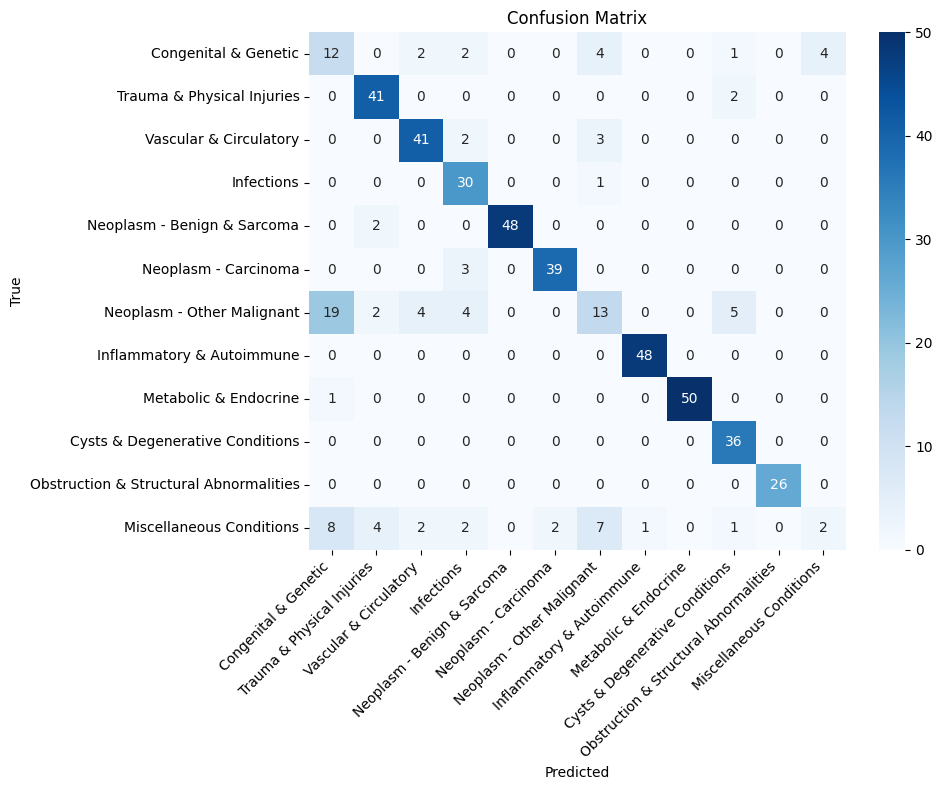

In [ ]:
multimodal_model.eval()
all_labels = []
all_preds = []
all_probs = []
i=0
with torch.no_grad():
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(test_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)
        print(i)
        outputs = multimodal_model(images, input_ids, attention_masks)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(outputs, dim=1)
        i+=1
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

conf_matrix = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


Classification Report:
                                        precision    recall  f1-score   support

                  Congenital & Genetic       0.30      0.48      0.37        25
            Trauma & Physical Injuries       0.84      0.95      0.89        43
                Vascular & Circulatory       0.84      0.89      0.86        46
                            Infections       0.70      0.97      0.81        31
           Neoplasm - Benign & Sarcoma       1.00      0.96      0.98        50
                  Neoplasm - Carcinoma       0.95      0.93      0.94        42
            Neoplasm - Other Malignant       0.46      0.28      0.35        47
             Inflammatory & Autoimmune       0.98      1.00      0.99        48
                 Metabolic & Endocrine       1.00      0.98      0.99        51
       Cysts & Degenerative Conditions       0.80      1.00      0.89        36
Obstruction & Structural Abnormalities       1.00      1.00      1.00        26
              M

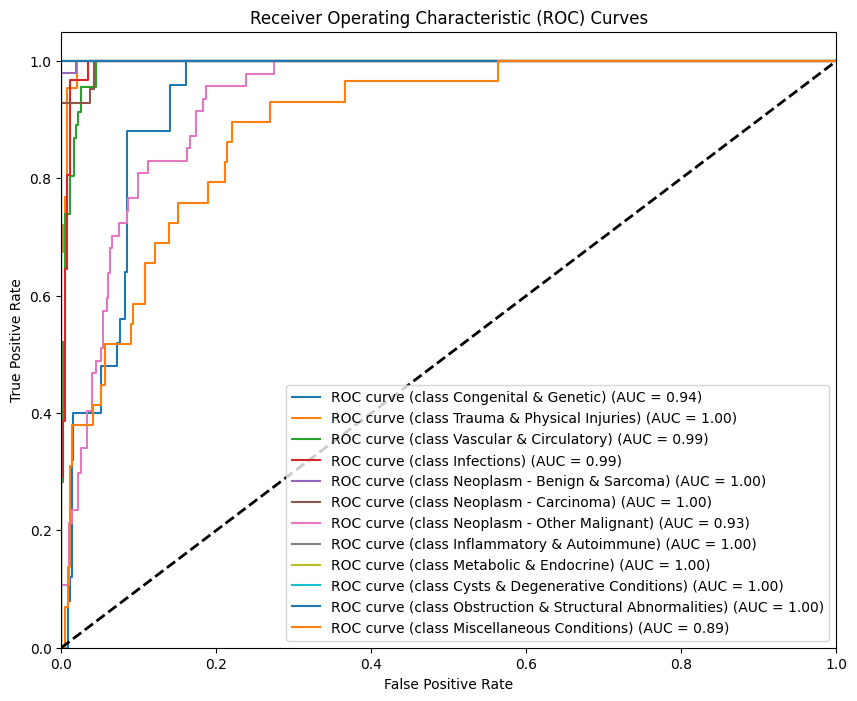


AUC-ROC for each class:
Class Congenital & Genetic: 0.9404
Class Trauma & Physical Injuries: 0.9974
Class Vascular & Circulatory: 0.9927
Class Infections: 0.9946
Class Neoplasm - Benign & Sarcoma: 0.9996
Class Neoplasm - Carcinoma: 0.9971
Class Neoplasm - Other Malignant: 0.9333
Class Inflammatory & Autoimmune: 1.0000
Class Metabolic & Endocrine: 1.0000
Class Cysts & Degenerative Conditions: 1.0000
Class Obstruction & Structural Abnormalities: 1.0000
Class Miscellaneous Conditions: 0.8911


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
import numpy as np

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(key) for key in label_mapping.keys()]))
C
from sklearn.preprocessing import label_binarize
num_classes = len(label_mapping)
y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_probs = np.array(all_probs)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-Average AUC-ROC: {macro_roc_auc:.4f}")

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {list(label_mapping.keys())[i]}) (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

print("\nAUC-ROC for each class:")
for i, class_name in enumerate(label_mapping.keys()):
    print(f"Class {class_name}: {roc_auc[i]:.4f}")

In [ ]:
multimodal_model.eval()

correct_predictions = 0
total_samples = 0
running_loss = 0.0

with torch.no_grad():
    for batch_idx, (images, input_ids, attention_masks, labels) in enumerate(train_dataloader):
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_masks = attention_masks.to(device)
        labels = labels.to(device)

        outputs = multimodal_model(images, input_ids, attention_masks)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

epoch_loss = running_loss / len(train_dataloader)
epoch_accuracy = correct_predictions / total_samples * 100

print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")
